### Import data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
!ls -a /content/drive/MyDrive/sign_language/

Mounted at /content/drive
'About dataset.pdf'	      amer_sign2.png   sign_mnist_test.csv
 american_sign_language.png   amer_sign3.png   sign_mnist_train.csv


In [2]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv("/content/drive/MyDrive/sign_language/sign_mnist_train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/sign_language/sign_mnist_test.csv")

# Split into X (input variables) and y (target variable), then convert to NumPy arrays
train_X = train_data.drop("label", axis=1).values
train_y = train_data["label"].values
test_X  = test_data.drop("label", axis=1).values
test_y  = test_data["label"].values

# Normalize pixel values and reshape to (num_samples, 28, 28, 1)
train_X = train_X.astype('float32') / 255.0
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.astype('float32') / 255.0
test_X = test_X.reshape(-1, 28, 28, 1)

In [4]:
# EDA
import numpy as np

# Display the first 5 samples of train_X
print("First 5 samples of train_X:")
print(train_X[:5])  # Slicing to show first 5 samples

# Display the first 5 labels of train_y
print("\nFirst 5 labels of train_y:")
print(train_y[:5])  # Slicing to show first 5 labels

# Display the first 5 samples of test_X
print("\nFirst 5 samples of test_X:")
print(test_X[:5])  # Slicing to show first 5 samples

# Display the first 5 labels of test_y
print("\nFirst 5 labels of test_y:")
print(test_y[:5])  # Slicing to show first 5 labels

# Print the shape of train_X
print("\nShape of train_X:")
print(train_X.shape)  # Keep this to check array dimensions

First 5 samples of train_X:
[[[[0.41960785]
   [0.4627451 ]
   [0.49803922]
   ...
   [0.6666667 ]
   [0.6666667 ]
   [0.6627451 ]]

  [[0.43529412]
   [0.4745098 ]
   [0.5058824 ]
   ...
   [0.67058825]
   [0.67058825]
   [0.6666667 ]]

  [[0.44313726]
   [0.48235294]
   [0.5137255 ]
   ...
   [0.67058825]
   [0.67058825]
   [0.67058825]]

  ...

  [[0.5568628 ]
   [0.5882353 ]
   [0.62352943]
   ...
   [0.7921569 ]
   [0.7882353 ]
   [0.78431374]]

  [[0.5568628 ]
   [0.5921569 ]
   [0.627451  ]
   ...
   [0.8       ]
   [0.79607844]
   [0.7921569 ]]

  [[0.5568628 ]
   [0.5921569 ]
   [0.627451  ]
   ...
   [0.8       ]
   [0.79607844]
   [0.7921569 ]]]


 [[[0.60784316]
   [0.6156863 ]
   [0.6117647 ]
   ...
   [0.5411765 ]
   [0.36078432]
   [0.42352942]]

  [[0.61960787]
   [0.62352943]
   [0.62352943]
   ...
   [0.5568628 ]
   [0.45490196]
   [0.56078434]]

  [[0.6313726 ]
   [0.6313726 ]
   [0.6313726 ]
   ...
   [0.5764706 ]
   [0.49019608]
   [0.54901963]]

  ...

  [[0.63529

# **Data Exploration and Preprocessing**

## Check for NA values and duplicate rows in each dataset and print if they exist

- Dataset: test_data - No NA values or duplicate rows
- Dataset: train_data - No NA values or duplicate rows

In [5]:
for name, data in zip(["test_data", "train_data"], [test_data, train_data]):
    na_count = data.isna().sum().sum()
    duplicate_count = data.duplicated().sum()
    if na_count > 0 or duplicate_count > 0:
        print(f"Dataset: {name}")
        if na_count > 0:
            print(f"  - NA values: {na_count}")
        if duplicate_count > 0:
            print(f"  - Duplicate rows: {duplicate_count}")
    else:
        print(f"Dataset: {name} - No NA values or duplicate rows")

Dataset: test_data - No NA values or duplicate rows
Dataset: train_data - No NA values or duplicate rows


## Visualize the data

- Visualize a few sample images (random samples) from the dataset to confirm the image format and understand how the data is represented.
- Plot a few of the images to get a visual sense of what they look like (since it's image data).

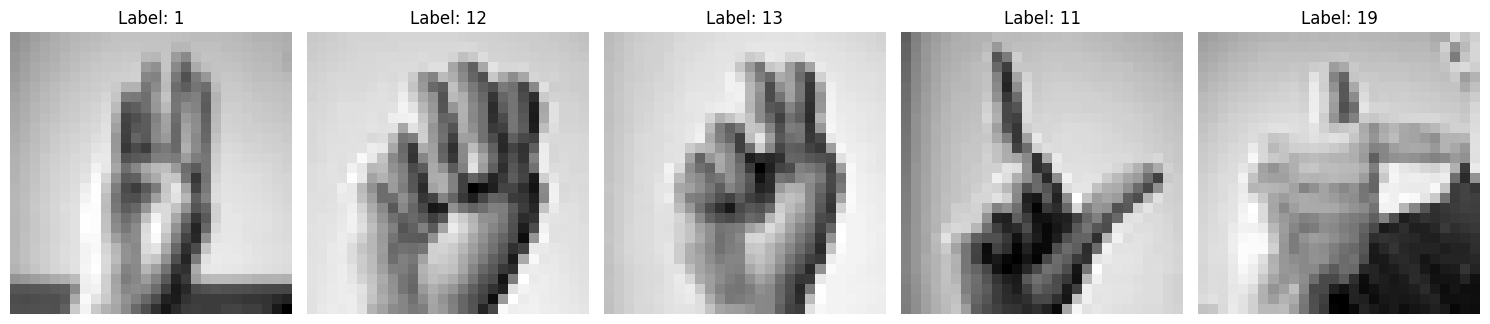

In [6]:
sample_indices = np.random.choice(train_X.shape[0], 5, replace=False) # Choose 5 samples
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    img = train_X[idx].reshape(28, 28) # train_X is already a NumPy array
    label = train_y[idx] # train_y is already a NumPy array

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

## Target Variable Distribution In Training Dataset

- The training dataset does not have class imbalance

<ipython-input-7-050b5cf50265>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_y, palette='viridis')


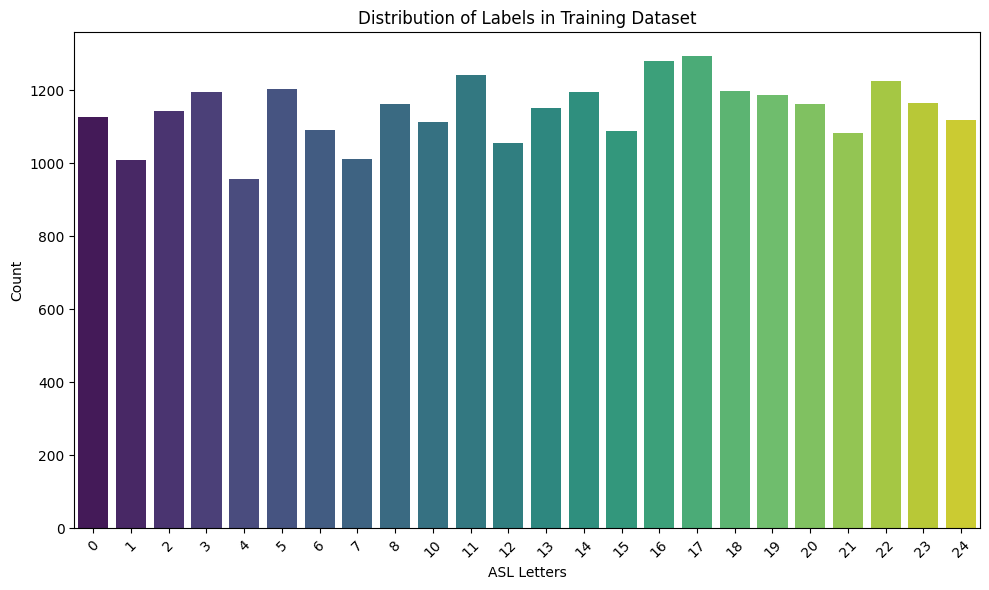

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x=train_y, palette='viridis')
plt.title('Distribution of Labels in Training Dataset')
plt.xlabel('ASL Letters')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **CNN models**

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import resize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

## Data Engineering

In [9]:
cnn_train_X = train_X.copy()
cnn_test_X  = test_X.copy()
cnn_train_y = train_y.copy()
cnn_test_y  = test_y.copy()

# There are 2 labels missing, so need to engineer train_y and test_y data and convert to integer
cnn_train_y = np.where(cnn_train_y.astype(int) < 9, cnn_train_y.astype(int), cnn_train_y.astype(int) - 1)
cnn_test_y = np.where(cnn_test_y.astype(int) < 9, cnn_test_y.astype(int), cnn_test_y.astype(int) - 1)

# Print out shapes and label ranges for verification
print("CNN Train Images shape:", cnn_train_X.shape)
print("CNN Test Images shape:", cnn_test_X.shape)
print("CNN Train Labels range:", cnn_train_y.min(), "to", cnn_train_y.max())
print("CNN Test Labels range:", cnn_test_y.min(), "to", cnn_test_y.max())

CNN Train Images shape: (27455, 28, 28, 1)
CNN Test Images shape: (7172, 28, 28, 1)
CNN Train Labels range: 0 to 23
CNN Test Labels range: 0 to 23


- I'm working on a image multi-class classification, CNNs are by far the most popular and effective models
- Conv2D layers: These layers apply convolution operations to extract features from the images.
- MaxPooling2D layers: These downsample the images, reducing the spatial dimensions and making the model more computationally efficient.
- Flatten layer: This layer flattens the 2D image data into a 1D vector, which is fed into the fully connected layers.
- Dense layers: These layers perform classification based on the extracted features.
- Dropout layer: This regularization technique helps reduce overfitting by randomly setting some of the neurons to zero during training.


## Building model

In [10]:
# Train
cnn_model = Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(24, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(cnn_train_X, cnn_train_y, epochs=10, batch_size=32, validation_split=0.2)

# Predict and Evaluate
def print_classification_metrics(model_name, y_true, y_pred):
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Precision: {precision:.4f}")
    print(f"{model_name} Recall: {recall:.4f}")
    print(f"{model_name} F1 Score: {f1:.4f}\n")
cnn_y_pred = cnn_model.predict(cnn_test_X)
print_classification_metrics("CNN", cnn_test_y, cnn_y_pred)

Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/step - accuracy: 0.2072 - loss: 2.5700 - val_accuracy: 0.7913 - val_loss: 0.6677
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.7551 - loss: 0.7079 - val_accuracy: 0.9335 - val_loss: 0.2205
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.8910 - loss: 0.3146 - val_accuracy: 0.9858 - val_loss: 0.0670
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.9508 - loss: 0.1496 - val_accuracy: 0.9958 - val_loss: 0.0273
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.9684 - loss: 0.0954 - val_accuracy: 0.9980 - val_loss: 0.0139
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9809 - loss: 0.0603 - val_accuracy: 0.9982 - val_loss: 0.0084
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9853 - loss: 0.0467 - val_accuracy: 0.9996 - val_loss: 0.0031
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9865 - loss: 0.0450 - 

In [13]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))
    # First Conv Layer: Tune number of filters from 32 to 128 in steps of 16.
    model.add(layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=16),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # Second Conv Layer: Tune filters from 32 to 128 in steps of 16.
    model.add(layers.Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=16),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # Third Conv Layer: Fixed 128 filters.
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    # Dense layer: Tune number of units from 64 to 256 in steps of 32.
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    # Dropout
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    # Output layer for 24 classes.
    model.add(layers.Dense(24, activation='softmax'))
    # Tune the learning rate: explore a wider range.
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Use Hyperband tuner for a more aggressive search.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperband_tuner',
    project_name='sign_language_tuning'
)
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Start the hyperparameter search.
tuner.search(
    cnn_train_X, cnn_train_y,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[stop_early]
)
tuner.results_summary()

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

best_model.fit(cnn_train_X, cnn_train_y, epochs=20, batch_size=32, validation_split=0.2)

# Predict and Evaluate
test_loss, test_acc = best_model.evaluate(cnn_test_X, cnn_test_y, verbose=1)
print(f"Best model test accuracy: {test_acc:.4f}")

y_pred_proba = best_model.predict(cnn_test_X)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(cnn_test_y, y_pred)
prec = precision_score(cnn_test_y, y_pred, average='weighted')
rec = recall_score(cnn_test_y, y_pred, average='weighted')
f1 = f1_score(cnn_test_y, y_pred, average='weighted')

print("CNN Accuracy:", f"{acc:.4f}")
print("CNN Precision:", f"{prec:.4f}")
print("CNN Recall:", f"{rec:.4f}")
print("CNN F1 Score:", f"{f1:.4f}")


Trial 30 Complete [00h 10m 11s]
val_accuracy: 0.05299581214785576

Best val_accuracy So Far: 1.0
Total elapsed time: 03h 14m 32s
Results summary
Results in hyperband_tuner/sign_language_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
conv1_filters: 96
conv2_filters: 64
dense_units: 96
dropout: 0.5
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 1.0

Trial 0026 summary
Hyperparameters:
conv1_filters: 128
conv2_filters: 32
dense_units: 160
dropout: 0.5
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 1.0

Trial 0027 summary
Hyperparameters:
conv1_filters: 48
conv2_filters: 32
dense_units: 128
dropout: 0.3
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 1.0

Trial 0024 summary
Hyperparameters:
conv1_filters: 112
conv2_filters: 96
dense_units: 192
dro